# load drifter processed pair data and derive statistics

In [1]:
import os
from glob import glob
#import pickle

#import dask
#import dask.bag as db
#import dask.dataframe as dd
#import dask.array as da
#from dask import delayed
from dask.distributed import Client
import xarray as xr
#import pandas as pd
#import geopandas
import numpy as np
#import datetime

#from scipy import signal
#import scipy.ndimage as im

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.drifters as edr

data_dir = '/work/ALT/swot/aval/syn/drifters/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, walltime='12:00:00', memory='20GB')
w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
#from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [4]:
cluster

In [5]:
def drop(ds, ndrop):
    vdrop = list(ds)
    for v in ndrop:
        vdrop.remove(v)
    return ds.drop(vdrop)

---

## load data

In [29]:
ds = xr.open_mfdataset(data_dir+'pairs_tfilt/joined_filtered_pairs_*.nc', 
                       concat_dim='index', parallel=True)

In [30]:
ds

<xarray.Dataset>
Dimensions:     (TIME: 721, index: 323114)
Coordinates:
  * TIME        (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0       (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    LON_0       (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    U_0         (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    V_0         (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    LAT_ERR_0   (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    LON_ERR_0   (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    U_ERR_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    V_ERR_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    DROGUE_0    (index, TIME) float64 dask.array<sh

In [31]:
ds = ds.drop('pair') # try to see if this breaks stacking further below
ds = ds.chunk({'index': 1e4})
ds.to_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr', mode='w')

---

In [6]:
ds = xr.open_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr')
ds = ds.chunk({'index': 5*1e3})

In [7]:
ndrop = ['v%d_0'%d for d in range(3)]
ndrop += ['v%d_1'%d for d in range(3)]
ndrop += [v+'_'+d for v in ['U','V','LON','LAT'] for d in ['0','1']]
ndrop

ds = drop(ds,ndrop)

In [8]:
ds

<xarray.Dataset>
Dimensions:  (TIME: 721, index: 323114)
Coordinates:
  * TIME     (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    LAT_0    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LAT_1    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LON_0    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LON_1    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    U_0      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    U_1      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    V_0      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    V_1      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    v0_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(500

In [9]:
ds0 = ds

In [10]:
print(ds0.nbytes/1e9)

26.092107496


In [53]:
#ds = ds.chunk({'index': 1000})
#ds.to_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr', mode='w')

In [8]:
#ds = xr.open_zarr(data_dir+'pairs_tfilt/joined_filtered_pairs.zarr')

---
## derives basic statistics

In [46]:
ds = ds0.persist()
#ds = ds0.isel(index=slice(0,10000)).persist()

Worker tcp://10.135.37.18:34026 restart in Job 5041994. This can be due to memory issue.
Worker tcp://10.135.37.18:45437 restart in Job 5042002. This can be due to memory issue.


In [14]:
ds

<xarray.Dataset>
Dimensions:  (TIME: 721, index: 323114)
Coordinates:
  * TIME     (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
Dimensions without coordinates: index
Data variables:
    v0_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    v1_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    v2_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    v0_1     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    v1_1     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>
    v2_1     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(1000, 721)>

In [15]:
for v in range(3):
    ds['v%d_mid'%v] = (ds['v%d_0'%v]+ds['v%d_1'%v])*.5

In [16]:
mds = ds.mean('TIME').persist()

In [21]:
mds = (edr.compute_lonlat(mds, v0='v0_0', v1='v1_0', v2='v2_0', \
                                lon_key='lon_0', lat_key='lat_0', dropv=False).persist())
mds = (edr.compute_lonlat(mds, v0='v0_1', v1='v1_1', v2='v2_1', \
                                lon_key='lon_1', lat_key='lat_1', dropv=False).persist())
mds = (edr.compute_lonlat(mds, v0='v0_mid', v1='v1_mid', v2='v2_mid', \
                                lon_key='lon_mid', lat_key='lat_mid', dropv=False).persist())

In [22]:
mds

<xarray.Dataset>
Dimensions:  (index: 323114)
Dimensions without coordinates: index
Data variables:
    v0_0     (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v1_0     (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v2_0     (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v0_1     (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v1_1     (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v2_1     (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v0_mid   (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v1_mid   (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    v2_mid   (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    lon_mid  (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    lat_mid  (index) float64 dask.array<shape=(323114,), chunksize=(1000,)>
    lon_0    (index) float64 dask.array<shape=(323114,), chunksi

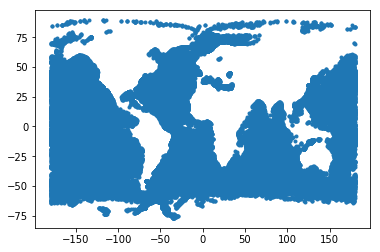

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mds.lon_mid, mds.lat_mid, '.')

In [23]:
mds['r'] = edr.haversine(mds.lon_0,mds.lat_0, mds.lon_1, mds.lat_1)

(array([11287., 17280., 22187., 27973., 33426., 38704., 43575., 46835.,
        47533., 34314.]),
 array([1.77580486e-02, 2.99833383e+01, 5.99489185e+01, 8.99144987e+01,
        1.19880079e+02, 1.49845659e+02, 1.79811239e+02, 2.09776820e+02,
        2.39742400e+02, 2.69707980e+02, 2.99673560e+02]),
 <a list of 10 Patch objects>)

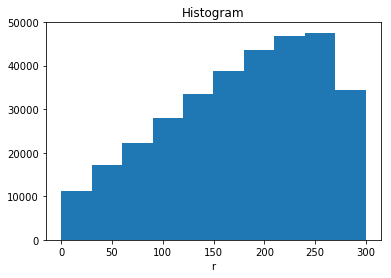

In [25]:
mds.r.plot.hist()

---
## computations of decorrelation length scales for velocity

In [11]:
ds.chunks

Frozen(SortedKeysDict({'index': (5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 3114), 'TIME': (721,)}))

In [12]:
ds = ds.drop('TIME') # try to see if this speeds up stack

In [13]:
ds

<xarray.Dataset>
Dimensions:  (TIME: 721, index: 323114)
Dimensions without coordinates: TIME, index
Data variables:
    LAT_0    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LAT_1    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LON_0    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LON_1    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    U_0      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    U_1      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    V_0      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    V_1      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    v0_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    v0_1     (index, TIME) float64 dask.array<shape=(323114, 721), chunks

In [14]:
ds['r'] = edr.haversine(ds.LON_0, ds.LAT_0, ds.LON_1, ds.LAT_1)
ds = ds.persist()

In [30]:
ds

<xarray.Dataset>
Dimensions:  (TIME: 721, index: 323114)
Dimensions without coordinates: TIME, index
Data variables:
    LAT_0    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LAT_1    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LON_0    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    LON_1    (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    U_0      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    U_1      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    V_0      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    V_1      (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    v0_0     (index, TIME) float64 dask.array<shape=(323114, 721), chunksize=(5000, 721)>
    v0_1     (index, TIME) float64 dask.array<shape=(323114, 721), chunks

In [31]:
from functools import partial

In [67]:
latb = np.arange(-70.,70.,1.)
latc = (latb[:-1]+latb[1:])*.5
lonb = np.arange(-180.,180.,1.)
lonc = (lonb[:-1]+lonb[1:])*.5
rb = np.arange(0.,300.,10.)
rc = (rb[:-1]+rb[1:])*.5

In [41]:
# https://github.com/pydata/xarray/issues/2817

def _bin(bins, v, vbin, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = v
    else:
        w = np.ones_like(v)
    #h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    h, edges = np.histogram(vbin, bins=bins, weights=w, density=False)
    return h[None,:]

dims = ['TIME']
#v = v.fillna(0.)
#lat = v.YC+0.*v

B = xr.apply_ufunc(partial(_bin, rb), ds.r, ds.r, kwargs={'weights': False},
                output_core_dims=[['rbin']], output_dtypes=[np.float64], 
                dask='parallelized',
                input_core_dims=[dims, dims],
                output_sizes={'rbin': len(rc)})
B = B.assign_coords(rbin=rc).rename('r_binned')

In [42]:
B = B.sum('index')

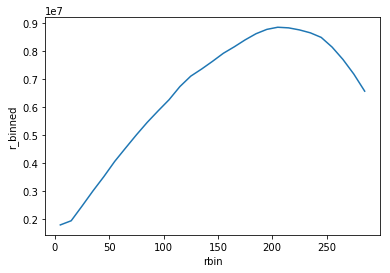

In [43]:
B.plot()

In [57]:
def _bin2d(bins1, bins2, v, vbin1, vbin2, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = v
    else:
        w = np.ones_like(v)
    #h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    h, edges1, edges2 = np.histogram2d(vbin1.flatten(), vbin2.flatten(), 
                                       bins=[bins1, bins2], weights=w.flatten(), density=False)
    return h[None,...]

dims = ['TIME']
#v = v.fillna(0.)
#lat = v.YC+0.*v

B = xr.apply_ufunc(partial(_bin2d, lonb, latb), ds.r, ds.LON_0, ds.LAT_0, 
                   kwargs={'weights': False},
                   output_core_dims=[['lon_b','lat_b']], output_dtypes=[np.float64], 
                   dask='parallelized',
                   input_core_dims=[dims, dims, dims],
                   output_sizes={'lon_b': len(lonc), 'lat_b': len(latc)})
B = B.assign_coords(lon_b=lonc, lat_b=latc).rename('N')

In [77]:
def _bin1d(bins, v, vbin, weights=True):

    if weights:
        w = v
    else:
        w = np.ones_like(v)
    h, edges = np.histogram(vbin, bins=bins, weights=w, density=False)
    return h[None,:]


def bin1d(v, vbin, bins, weights, bin_dim='bin_dim', name='binned_array'):
    # wrapper around apply_ufunc
    dims = ['TIME'] # core dim
    bins_c = (bins[:-1]+bins[1:])*.5
    out = xr.apply_ufunc(partial(_bin1d, bins), v, vbin, kwargs={'weights': weights},
                    output_core_dims=[[bin_dim]], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={bin_dim: len(bins_c)})
    out = out.assign_coords(**{bin_dim: bins_c}).rename(name)
    return out

def _bin2d(bins1, bins2, v, vbin1, vbin2, weights=True):
    # wrapper around apply_ufunc
    if weights:
        w = v
    else:
        w = np.ones_like(v)
    h, edges1, edges2 = np.histogram2d(vbin1.flatten(), vbin2.flatten(), 
                                       bins=[bins1, bins2], weights=w.flatten(), density=False)
    return h[None,...]

def bin2d(v, vbin1, bins1, vbin2, bins2, weights, 
          bin_dim1='bin_dim1', bin_dim2='bin_dim2', name='binned_array'):
    # wrapper around apply_ufunc
    dims = ['TIME'] # core dim
    bins1_c = (bins1[:-1]+bins1[1:])*.5
    bins2_c = (bins2[:-1]+bins2[1:])*.5
    out = xr.apply_ufunc(partial(_bin2d, bins1, bins2), v, vbin1, vbin2, 
                       kwargs={'weights': weights},
                       output_core_dims=[[bin_dim1,bin_dim2]], output_dtypes=[np.float64], 
                       dask='parallelized',
                       input_core_dims=[dims, dims, dims],
                       output_sizes={bin_dim1: len(bins1_c), bin_dim2: len(bins2_c)})
    out = out.assign_coords(**{bin_dim1: bins1_c, bin_dim2: bins2_c}).rename(name)
    return out

In [78]:
V = bin1d(ds.r, ds.r, rb, False, bin_dim='rb', name='Ncount')
V = V.sum('index')

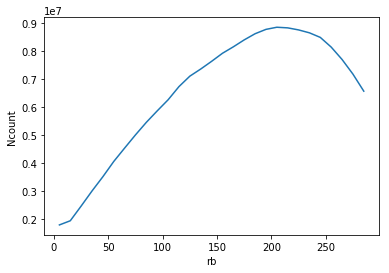

In [80]:
V.plot()

In [74]:
V = bin2d(ds.r, ds.LON_0, lonb, ds.LAT_0, latb, False, bin_dim1='lonb', bin_dim2='latb', name='Ncount')
V = V.sum('index')

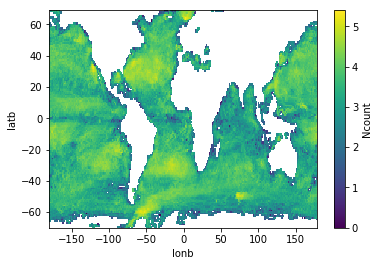

In [75]:
np.log10(V).plot(x='lonb', y='latb')

In [102]:
V = bin1d(ds.r, ds.r, rb, False, bin_dim='rb', name='Ncount').sum('index')
ods = V.to_dataset()
#
V = bin1d(ds.U_0*ds.U_1, ds.r, rb, True, bin_dim='rb', name='U1U0')
ods['U1U0'] = V.sum('index')/ods['Ncount']
#
V = bin1d(ds.U_0*ds.U_0, ds.r, rb, True, bin_dim='rb', name='U0U0')
ods['U0U0'] = V.sum('index')/ods['Ncount']
V = bin1d(ds.U_1*ds.U_1, ds.r, rb, True, bin_dim='rb', name='U1U1')
ods['U1U1'] = V.sum('index')/ods['Ncount']
#

In [99]:
ods = ods.persist()

In [100]:
ods

<xarray.Dataset>
Dimensions:  (rb: 29)
Coordinates:
  * rb       (rb) float64 5.0 15.0 25.0 35.0 45.0 ... 255.0 265.0 275.0 285.0
Data variables:
    Ncount   (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U1U0     (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U0U0     (rb) float64 dask.array<shape=(29,), chunksize=(29,)>
    U1U1     (rb) float64 dask.array<shape=(29,), chunksize=(29,)>

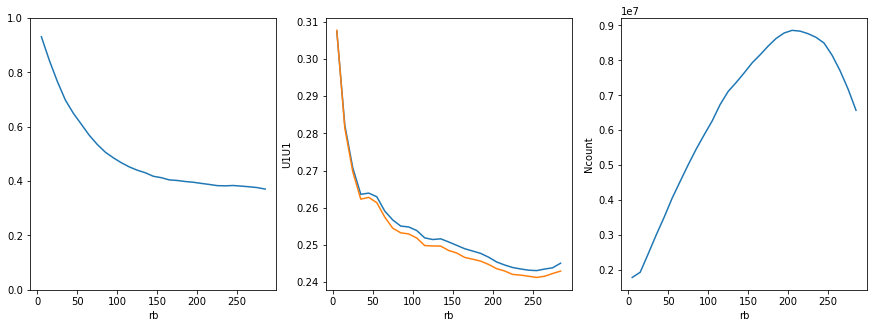

In [104]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
(ods.U1U0/np.sqrt(ods.U0U0*ods.U1U1)).plot(ax=ax)
ax.set_ylim(0.,1.)
ax = fig.add_subplot(132)
np.sqrt(ods.U0U0).plot(ax=ax)
np.sqrt(ods.U1U1).plot(ax=ax)
ax = fig.add_subplot(133)
ods.Ncount.plot(ax=ax)

In [15]:
#ds['r'] = edr.haversine(ds.LON_0, ds.LAT_0, ds.LON_1, ds.LAT_1)
#%time ds = ds.stack(point=['index','TIME']).persist()

distributed.utils_perf - WARNING - full garbage collections took 64% CPU time recently (threshold: 10%)


CPU times: user 1min 39s, sys: 14.1 s, total: 1min 53s
Wall time: 1min 51s


In [16]:
ds

<xarray.Dataset>
Dimensions:  (point: 232965194)
Coordinates:
  * point    (point) MultiIndex
  - index    (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - TIME     (point) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
Data variables:
    LAT_0    (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    LAT_1    (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    LON_0    (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    LON_1    (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    U_0      (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    U_1      (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    V_0      (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    V_1      (point) float64 dask.array<shape=(232965194,), chunksize=(7210000,)>
    v0_0     (point) float64 dask.array<shape=(232965194,), chunksize=(7

In [17]:
#%time ds = ds.stack(point=['index','TIME']) #.chunk({'point':1e6})  # 721000
#ds['r'] = edr.haversine(ds.LON_0, ds.LAT_0, ds.LON_1, ds.LAT_1).persist()

In [17]:
UU = (ds.U_0*ds.U_1)

In [18]:
UU

<xarray.DataArray (point: 232965194)>
dask.array<shape=(232965194,), dtype=float64, chunksize=(7210000,)>
Coordinates:
  * point    (point) MultiIndex
  - index    (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - TIME     (point) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

In [19]:
rbins = np.arange(0,300,10)
%time uu = UU.groupby_bins(ds.r, bins=rbins).mean()

distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2b7797934080>>
Traceback (most recent call last):
  File

KeyboardInterrupt: 

In [20]:
uu.plot()


KeyboardInterrupt



In [21]:
np.arange(0,300,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290])

In [ ]:
deg2rad = np.pi/180.
def compute_lonlat(df, dropv=True, v0='v0', v1='v1', v2='v2',
                   lon_key='LON', lat_key='LAT'):
    # renormalize vectors
    #n = df[v0] + df[v1] + df[v2]
    #n = np.abs(df[v0])+np.abs(df[v1]**2+df[v2]**2)
    #n = df[v2]*df[v2] + df[v1]*df[v1] + df[v2]*df[v2]
    #n = np.sqrt(df[v0]*df[v0]+df[v1]*df[v1]+df[v2]*df[v2])
    n = np.sqrt(df[v0]**2+df[v1]**2+df[v2]**2)
    df[v0], df[v1], df[v2] = df[v0]/n, df[v1]/n, df[v2]/n
    # estimate LON/LAT
    #df[lon_key] = n
    #df[lat_key] = n
    df[lon_key] = np.arctan2(df[v1],df[v0])/deg2rad
    df[lat_key] = np.arctan2(df[v2],np.sqrt(df[v0]**2+df[v1]**2))/deg2rad
    return df


---

In [74]:
client.restart()

Worker tcp://10.135.36.43:40910 restart in Job 5038493. This can be due to memory issue.
Worker tcp://10.135.36.43:36956 restart in Job 5038494. This can be due to memory issue.
Worker tcp://10.135.36.43:40688 restart in Job 5038495. This can be due to memory issue.
Worker tcp://10.135.36.68:35990 restart in Job 5038499. This can be due to memory issue.
Worker tcp://10.135.36.105:36102 restart in Job 5038502. This can be due to memory issue.
Worker tcp://10.135.36.67:38743 restart in Job 5038498. This can be due to memory issue.
Worker tcp://10.135.36.55:43525 restart in Job 5038497. This can be due to memory issue.
Worker tcp://10.135.36.48:45309 restart in Job 5038496. This can be due to memory issue.
Worker tcp://10.135.36.69:37481 restart in Job 5038501. This can be due to memory issue.
Worker tcp://10.135.36.69:35500 restart in Job 5038500. This can be due to memory issue.


Client Scheduler: tcp://10.135.39.58:41670 Dashboard: http://10.135.39.58:8787/status,Cluster Workers: 10 Cores: 10 Memory: 200.00 GB


In [105]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
